# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [6]:
from unityagents import UnityEnvironment
import numpy as np

from collections import OrderedDict
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

In [7]:
class Model(nn.Module):
    """Creates neural network model with specified layers.
    
    Args:
        input_size (int): number of input parameters for neural network
        output_size (int): number of output parameters for neural netowrk
        hidden_layers (array[int]): hidden layers' number of nodes
    """
    def __init__(self, input_size, output_size, hidden_layers):
        super(Model, self).__init__(); 
        seq = [nn.Linear(input_size, hidden_layers[0])]
        for i in range(1, len(hidden_layers)):
            seq = seq + [nn.LeakyReLU()]
            seq = seq + [nn.Linear(hidden_layers[i-1], hidden_layers[i])]
            
        seq = seq + [nn.LeakyReLU()]
        seq = seq + [nn.Linear(hidden_layers[-1], output_size)]
        
        self.model = nn.Sequential(*seq)
        
    def forward(self, state):
        """Makes a forward pass through neural network model
        
        Returns:
            Array of <output_size> numbers
        """
        return self.model.forward(state)


In [8]:
class Agent():

    """RL agent to train using DQN
    
    Args:
        state_size (int): number of states
        action_size (int): number of actions an agent can take
        learning_rate (float): rate of learning
        replay_buffer (ReplayBuffer): replay buffer instance to use while using experience replay
        batch_size (int): number of experience tuples to take while learning
        update_every (int): how many steps need to pass to learn from experiences
        gamma (float): how much to value next Q-targets while learning
    """
    def __init__(self, state_size, action_size, hidden_layers, learning_rate, replay_buffer, batch_size, update_every, gamma):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.update_every = update_every
        self.gamma = gamma

        # Q-Network
        self.local = Model(state_size, action_size, hidden_layers).to(device)
        self.target = Model(state_size, action_size, hidden_layers).to(device)
        self.optimizer = optim.Adam(self.local.parameters(), lr=learning_rate)

        # Replay memory
        self.memory = replay_buffer
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        """Record an action taken
        
        Args:
            state (array): the state the agent was before taking the step
            action (array): the action the agent took
            reward (float): the reward the agent got from taking the step when in state <arg:state>
            next_state (array): the next state agent is in after taking the <arg: action> from state <arg:state>
            done (bool): is the episode finished then true, else false
        """
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % self.update_every
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)

    def act(self, state, eps=0.):
        """Select an action in the given state
        
        Args:
            state (array): the state the agent is in
            eps (float, optional): parameter for epsilon-greedy policy
            
        Returns:
            The action the agent has chosen
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.local.eval()
        with torch.no_grad():
            action_values = self.local(state)
        self.local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        """Learn from experiences
        
        Args:
            experiences (array): tuples from experience replay buffer
            gamma (float): parameter to value the next Q-targets in the learning process
        """
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.soft_update(self.local, self.target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        """Make update of the target network weights
        
        Args:
            local_model (Model): local neural network model
            target_model (Model): target neural network model
            tau (float): how much value the local model weights in updating the target weights
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)



In [9]:
from collections import namedtuple, deque

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [10]:
def dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Training loop for Agent RL agent"""
    
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0 
        for t in range(max_t):
            action = agent.act(state, eps).astype(int)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>=13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.local.state_dict(), 'checkpoint.pth')
            break
    return scores


In [11]:
BUFFER_SIZE = int(5e4)  # replay buffer size
BATCH_SIZE = 32         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network
SEED = 42
EPISODES = 2000
MAX_TIMESTEPS = int(1e3)
hidden_layers = [500, 200, 100]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(SEED)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

action_size = brain.vector_action_space_size
state_size = len(env_info.vector_observations[0])

print("State size:  {}".format(state_size))
print("Action size: {}".format(action_size))
print("Layers: {} - {} - {}".format(state_size, hidden_layers, action_size))

State size:  37
Action size: 4
Layers: 37 - [500, 200, 100] - 4


In [12]:
replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
agent = Agent(state_size, action_size, hidden_layers, LR, replay_buffer, BATCH_SIZE, UPDATE_EVERY, GAMMA)

scores = dqn(agent, EPISODES, MAX_TIMESTEPS)

Episode 100	Average Score: 0.64
Episode 200	Average Score: 4.13
Episode 300	Average Score: 7.97
Episode 400	Average Score: 12.25
Episode 438	Average Score: 13.02
Environment solved in 338 episodes!	Average Score: 13.02


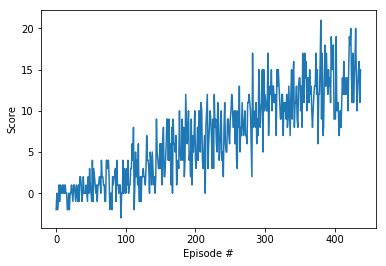

In [16]:
import matplotlib.pyplot as plt
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
env.close()